In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import datetime
import copy
import re
import yaml
import uuid
import warnings
import time
import inspect
import math

import numpy as np
import pandas as pd
from functools import partial, reduce
from random import shuffle
import random
from PIL import Image
from matplotlib import pyplot as plt
from datetime import datetime


import torch
from torch import nn, optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from torchvision.models import resnet
from torchvision.models import resnet18
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.nn.parameter import Parameter
from torch.nn import init

import tensorflow as tf
from tqdm.autonotebook import tqdm
#from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import metrics as mtx
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error, r2_score

**1. prepare the data**

In [3]:
#load the data and select 0 and 7 from the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
train_mask = np.isin(y_train, [0,7])
test_mask = np.isin(y_test, [0,7])
x_train, y_train = x_train[train_mask], y_train[train_mask]
x_test, y_test = x_test[test_mask], y_test[test_mask]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train = x_train[:12000]
y_train = y_train[:12000]
x_test = x_test[:2000]
y_test = y_test[:2000]

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
#function that generates the proportion of 0 randomly
#the output is a list contains numbers between 0 and 100 randomly 
def generate_proportion_0(size, batch_size):
  random_ = np.random.randint(1, batch_size, size=size)
  sample_number = []
  for i in range(random_.shape[0]):
    sample_number.append(random_[i,0])
  return sample_number

In [5]:
#generate the proportion of 0 lists of train set, validation set and test set
zero_proportion_train = generate_proportion_0((90,1), 100)
zero_proportion_val = generate_proportion_0((30,1), 100) 
zero_proportion_test = generate_proportion_0((20,1), 100)

In [6]:
#define function that generates train, validation, test set
def generate_dataset(train_bags_num, zero_proportion, bag_size, zero_idx, seven_idx, max_idx):
  bags_train = {}
  bags_train_labels = {}
  for bag_idx in range(train_bags_num):
    bags_train[str(bag_idx)] = []
    count = 0
    while count < zero_proportion[bag_idx]:
      if zero_idx >= max_idx:
        zero_idx = 0
      if y_train[zero_idx] == 0:
        bags_train[str(bag_idx)].append(x_train[zero_idx])
        bags_train_labels[str(bag_idx)] = [zero_proportion[bag_idx]/100]
        count += 1
        zero_idx += 1
      else:
        zero_idx += 1
    count = 0
    while count < (bag_size-zero_proportion[bag_idx]):
      if seven_idx >= max_idx:
        seven_idx = 0
      if y_train[seven_idx] == 7:
        bags_train[str(bag_idx)].append(x_train[seven_idx])
        seven_idx += 1
        count += 1
      else:
        seven_idx += 1
    state=np.random.get_state()
    np.random.shuffle(bags_train[str(bag_idx)])
    np.random.set_state(state)
    np.random.shuffle(bags_train_labels[str(bag_idx)])
  return bags_train, bags_train_labels, zero_idx, seven_idx



In [7]:
#generate train set, validation set and test set. train set: 90 bags validation set: 30 bags test set: 20 bags
zero_idx = 0
seven_idx = 0
bags_train, bags_train_labels, zero_idx, seven_idx = generate_dataset(90, zero_proportion_train, 100, zero_idx, seven_idx, 12000)
bags_val, bags_val_labels, zero_idx, seven_idx = generate_dataset(30, zero_proportion_val, 100, zero_idx, seven_idx, 12000)
bags_test, bags_test_labels, zero_idx, seven_idx = generate_dataset(20, zero_proportion_test, 100, zero_idx, seven_idx, 2000)

In [8]:
#define dataset
transform = transforms.Compose([ToTensor()])
class MyDataset(Dataset):
  def __init__(self, data, patch_size = 28, num_instances = 100, num_bags=90):
    self.data = data
    self._num_instances = num_instances
    self._patch_size = patch_size
    self._num_bags = num_bags
    self._transforms = transform


  def __len__(self):
    return len(self.data[1])


  def __getitem__(self, index):
    bag_imgs = np.array(self.data[0][str(index)])
    bag_size = bag_imgs.shape[0]
    bag_size = 100 #need to be deleted
    img_tensor_list = list()
    for i in range(bag_size):
      img = bag_imgs[i]
      img = Image.fromarray(np.uint8(img))
      img = img.convert("RGB")
      img_tensor = self._transforms(img)
      img_tensor_list.append(img_tensor)
    label = np.array(self.data[1][str(index)])
    label = torch.as_tensor(label, dtype=torch.float32)
    bag_tensor = torch.stack(img_tensor_list, dim=0)

    return bag_tensor, label
  


In [9]:
#create dataset and dataloader

def custom_collate_fn(batch):
	sample_tensors_list, label_tensors_list = zip(*batch)
	return torch.cat(sample_tensors_list,dim=0), torch.stack(label_tensors_list,dim=0)
 
batchsize = 1
train_dataset = MyDataset((bags_train, bags_train_labels, 90))
val_dataset = MyDataset((bags_val, bags_val_labels, 30))
test_dataset = MyDataset((bags_test, bags_test_labels,20))

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, shuffle=True, collate_fn=custom_collate_fn)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batchsize, shuffle=False, collate_fn=custom_collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize, shuffle=False, collate_fn=custom_collate_fn)

**2.define the MIL model**

In [10]:
class DistributionPoolingFilter(nn.Module):
	__constants__ = ['num_bins', 'sigma']

	def __init__(self, num_bins=21, sigma=0.0167):
		super(DistributionPoolingFilter, self).__init__()

		self.num_bins = num_bins
		self.sigma = sigma
		self.alfa = 1/math.sqrt(2*math.pi*(sigma**2))
		self.beta = -1/(2*(sigma**2))

		sample_points = torch.linspace(0,1,steps=num_bins, dtype=torch.float32, requires_grad=False)
		self.register_buffer('sample_points', sample_points)


	def extra_repr(self):
		return 'num_bins={}, sigma={}'.format(
			self.num_bins, self.sigma
		)


	def forward(self, data):
		batch_size, num_instances, num_features = data.size()

		sample_points = self.sample_points.repeat(batch_size,num_instances,num_features,1)

		data = torch.reshape(data,(batch_size,num_instances,num_features,1))

		diff = sample_points - data.repeat(1,1,1,self.num_bins)
		diff_2 = diff**2

		result = self.alfa * torch.exp(self.beta*diff_2)

		out_unnormalized = torch.sum(result,dim=1)

		norm_coeff = torch.sum(out_unnormalized, dim=2, keepdim=True)

		out = out_unnormalized / norm_coeff
		
		return out


In [11]:
class FeatureExtractor(nn.Module):

  def __init__(self, num_features=32):
    super(FeatureExtractor, self).__init__()
    self._model_conv = resnet18(pretrained=True)
    num_ftrs = self._model_conv.fc.in_features
    self._model_conv.fc = nn.Linear(num_ftrs, num_features)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    out = self._model_conv(x)
    out = self.relu(out)
    return out

class RepresentationTransformation(nn.Module):
	def __init__(self, num_features=32, num_bins=11, num_classes=10):
		super(RepresentationTransformation, self).__init__()

		self.fc = nn.Sequential(
			nn.Dropout(0.5),
			nn.Linear(num_features * num_bins, 384),
			nn.ReLU(),
			nn.Dropout(0.5),
			nn.Linear(384, 192),
			nn.ReLU(),
			nn.Dropout(0.5),
			nn.Linear(192, num_classes)
			)

	def forward(self, x):

		out = self.fc(x)

		return out

class Model(nn.Module):

	def __init__(self, num_classes=10, num_instances=32, num_features=32, num_bins=11, sigma=0.1):
		super(Model, self).__init__()
		self._num_classes = num_classes
		self._num_instances = num_instances
		self._num_features = num_features
		self._num_bins = num_bins
		self._sigma = sigma

		# feature extractor module
		self._feature_extractor = FeatureExtractor(num_features=num_features)

		# MIL pooling filter
		self._mil_pooling_filter = DistributionPoolingFilter(num_bins=num_bins, sigma=sigma)

		# bag-level representation transformation module
		self._representation_transformation = RepresentationTransformation(num_features=num_features, num_bins=num_bins, num_classes=num_classes)


	def forward(self, x):

		out = self._feature_extractor(x)
		out = torch.reshape(out,(-1,self._num_instances,self._num_features))

		out = self._mil_pooling_filter(out)
		out = torch.flatten(out, 1)

		out = self._representation_transformation(out)

		return out



**3.construct the model**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patchsize = 28
numinstances = 100
numfeatures = 128
numbins = 21
sigma = 0.05
numclasses = 1
learning_rate = 1e-4/5
num_epochs = 200

model = Model(num_classes=numclasses, num_instances=numinstances, num_features=numfeatures, num_bins=numbins, sigma=sigma)
model.to(device)

In [13]:
#construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=0.0005)

#define loss criterion
criterion = torch.nn.L1Loss()

#metrics function file
current_time = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
metrics_dir = '/content/drive/My Drive/zeroseven/metrics_file'
metrics_file = '{}/loss_metrics__{}.txt'.format(metrics_dir,current_time)  


**4.train the model**

In [ ]:
save_interval = 10
models_dir = '.'
val_bags_num = 30
train_bags_num = 90

r2 = []


for epoch in range(num_epochs):
	print('############## EPOCH - {} ##############'.format(epoch+1))
	training_loss = 0
	validation_loss = 0

	y_truth_r2 = []
	y_pred_r2 = []

	# train for one epoch
	print('******** training ********')
	num_predictions = 0
	pbar = tqdm(total=len(train_data_loader))
	model.train()
	for images, targets in train_data_loader:
		images = images.to(device)
		targets = targets.to(device)
		# zero the parameter gradients
		optimizer.zero_grad()
		# forward + backward + optimize
		y_logits = model(images)
	
		loss = criterion(y_logits, targets)
		loss.backward()
		optimizer.step()
		training_loss += loss.item()*targets.size(0)
		pbar.update(1)

		y_truth_r2.append(targets)
		y_pred_r2.append(y_logits)
	 

	training_loss /= train_bags_num
	print('train_loss\n',training_loss)
	pbar.close()
 
	r2.append(r2_score(y_truth_r2, y_pred_r2))
 
	print('*******validation***********')
  
	pbar = tqdm(total=len(val_data_loader))
  
	model.eval() 
	with torch.no_grad():
		for images, targets in val_data_loader:
			images = images.to(device)
			targets = targets.to(device)

			# forward
			y_logits = model(images)
			loss = criterion(y_logits, targets)
			validation_loss += loss.item()*targets.size(0)

			pbar.update(1)

	validation_loss /= val_bags_num

	print('num_predic\n',num_predictions)

	print('validation_loss:\n',validation_loss)
	pbar.close()

	print('Epoch=%d ### training_loss=%5.3f' % (epoch+1, training_loss))
 
  # logging loss values into metrics file
	with open(metrics_file,'a') as f_metrics_file:
		f_metrics_file.write('%d\t%5.3f\t%5.3f\n' % (epoch+1, training_loss, validation_loss))


In [16]:
#save model
model_weights_filename = '{}/model_weights__{}__{}.pth'.format(models_dir,current_time,epoch+1)
state_dict = {	'model_state_dict': model.state_dict(),
				'optimizer_state_dict': optimizer.state_dict()}
torch.save(state_dict, model_weights_filename)
print("Model weights saved in file: ", model_weights_filename)

Model weights saved in file:  ./model_weights__2022_02_02__19_50_53__200.pth


**5.plot loss, r2**

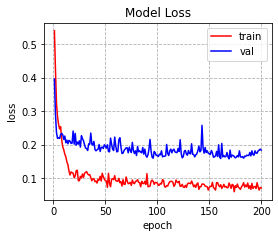

In [20]:
data_arr = np.loadtxt(metrics_file, dtype='float', comments='#', delimiter='\t')
step_size = 1
steps = np.arange(data_arr.shape[0]) + 1
train_loss = data_arr[:,1]
val_loss = data_arr[:,2]

ind_start = 0
ind_step = step_size
if ind_step>1:
	ind_start = ind_step - 1

ind_end = len(steps) + 1
#ind_end = 200


fig, ax = plt.subplots(figsize=(4,3))
plt.plot(steps[ind_start:ind_end:ind_step], train_loss[ind_start:ind_end:ind_step], 'r', label="train")
plt.plot(steps[ind_start:ind_end:ind_step], val_loss[ind_start:ind_end:ind_step], 'b', label="val")
plt.xlabel('epoch')
plt.ylabel('loss')
ax.set_title('Model Loss')
plt.grid(linestyle='--')
plt.legend()

fig.subplots_adjust(left=0.18, bottom=0.16, right=0.97, top=0.98, wspace=0.20 ,hspace=0.20 )
fig.savefig('{}.png'.format(metrics_file[:-4]),dpi=200)

plt.show()
plt.close('all')


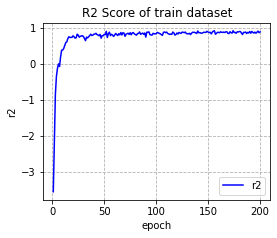

In [22]:
#plot R2 Score
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(steps[0:200:1], r2[0:200:1], 'b', label="r2")
plt.xlabel('epoch')
plt.ylabel('r2')
plt.grid(linestyle='--')
ax.set_title('R2 Score of train dataset')
plt.legend()

fig.subplots_adjust(left=0.18, bottom=0.16, right=0.97, top=0.98, wspace=0.20 ,hspace=0.20 )
fig.savefig('{}.png'.format(metrics_file[:-4]),dpi=200)

plt.show()
plt.close('all')

**6.test**

In [80]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(num_classes=numclasses, num_instances=numinstances, num_features=numfeatures, num_bins=numbins, sigma=sigma)
model.to(device)
init_model_file = model_weights_filename
state_dict = torch.load(init_model_file, map_location=device)
model.load_state_dict(state_dict['model_state_dict'])
print('weights loaded successfully!!!\n{}'.format(init_model_file))
num_bags = 1
model.eval()
data_folder_path='/content/drive/My Drive/zeroseven/zeroseven_data'
with torch.no_grad():

	for i in range(num_bags):
		bag_id = i
		print('bag {}/{}: {}'.format(i+1,num_bags, bag_id))

		bag_data_folder_path = '{}/{}'.format(data_folder_path,bag_id)
		if not os.path.exists(bag_data_folder_path):
			os.makedirs(bag_data_folder_path)

		test_metrics_filename = '{}/bag_predictions_{}.txt'.format(bag_data_folder_path, bag_id)
  
		for images, targets in test_data_loader:
			images = images.to(device)
			# get logits from model
			batch_logits = model(images)
			batch_probs = batch_logits
			batch_probs_arr = batch_probs.cpu().numpy()

			num_samples = targets.size(0)
   
			# print('num_samples: {}'.format(num_samples))

			batch_truths = np.asarray(targets.numpy(),dtype=np.float32)
   

			with open(test_metrics_filename,'a') as f_metrics_file:

        #f_metrics_file.write('bag_id\t')

				for b in range(num_samples):
					f_metrics_file.write('{}_{}\t'.format(bag_id,bag_id))
					f_metrics_file.write('{:.3f}\t'.format(batch_truths[b,0]))
					f_metrics_file.write('{:.3f}\n'.format(batch_probs_arr[b,0]))

					bag_id += 1


weights loaded successfully!!!
./model_weights__2022_02_02__19_50_53__200.pth
bag 1/1: 0


In [ ]:
#plot prediction vs. ground truth
data_file = '{}/{}/bag_predictions_0.txt'.format(data_folder_path,0)
data = np.loadtxt(data_file, delimiter='\t', comments='#', dtype=str)
temp_truth = np.asarray(data[:,1], dtype=float)
temp_prob = np.asarray(data[:,2], dtype=float)
fig, ax = plt.subplots(figsize=(3,3))

ax.plot([0,1], [0,1], linestyle='--', color='blue', zorder=1)
ax.scatter(temp_prob,temp_truth, color='k', zorder=2, alpha=0.7, s=16)
ax.set_xlabel('Percentage of 0 (model prediction)')
ax.set_ylabel('Percentage of 0 (Ground truth)')
ax.set_xlim((-0.05,1.05))
ax.set_xticks(np.arange(0,1.05,0.2))
ax.set_ylim((-0.05,1.05))
ax.set_yticks(np.arange(0,1.05,0.2))
ax.set_axisbelow(True)
ax.grid()
ax.set_title('predictions & ground truth relations')
fig.tight_layout()
fig_filename = '{}/patient_level_scatter_plot__mil.png'.format(data_folder_path)
fig.savefig(fig_filename, dpi=200)

plt.show()